In [1]:
import gymnasium
import numpy as np
import pandas as pd

import gym_trading

### TradingEnv
TradingEnv and TradingEnv2 are going to be deprecated in the future.

Better scroll down and take a look at TradingEnv3 API

In [2]:
def process_data(env):
    price = env.df.close
    
    # mask = list(range(0, -20, -1))  # negative indices look into the future, sanity checking
    mask = list(range(20))            # positive indices look into the past
    features = pd.concat(
        [
            (env.df.close.shift(mask[i]) - env.df.close.shift(mask[i + 1]))
            / (env.df.close.shift(mask[i]) + env.df.close.shift(mask[i + 1]))
            for i, _ in enumerate(mask[:-1])
        ],
        axis=1,
    ).fillna(0).to_numpy()

    return price, features

In [3]:
def env_fn():
    df = gym_trading.datasets.BITCOIN_USD_1H
    env = gym_trading.envs.TradingEnv(
        df=df,
        comission_fee=0.005,
        process_data=process_data,
        max_episode_steps=24*12,
    )
    return env

env = env_fn()
# env = gymnasium.vector.SyncVectorEnv([env_fn for _ in range(16)])


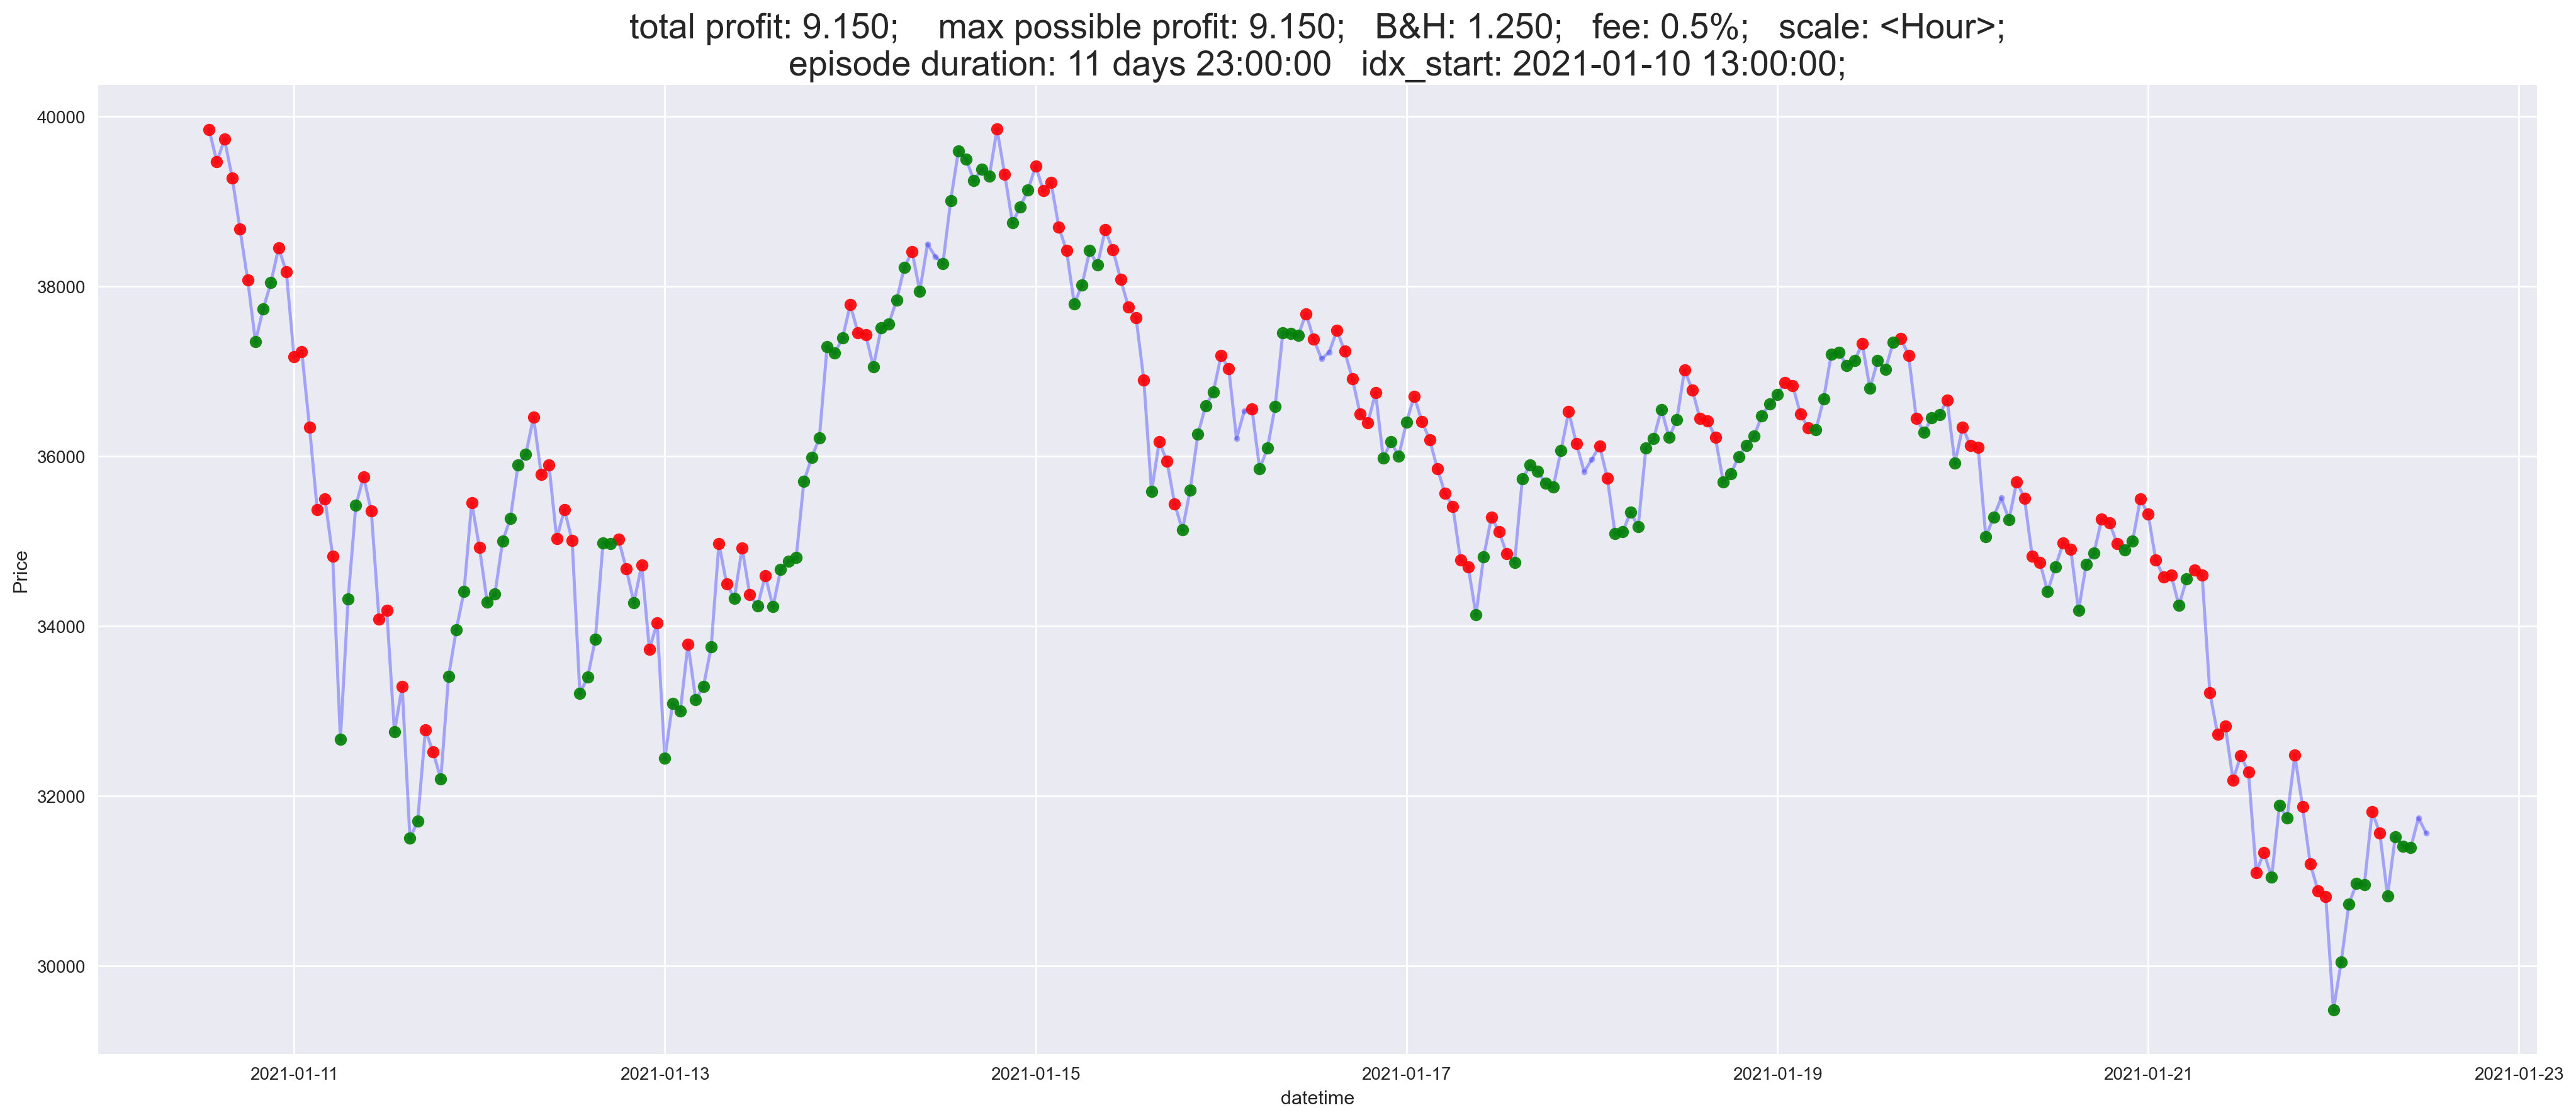

In [4]:
obs, _ = env.reset()
while True:
    # obs: dict[features: np.ndarray, price_change: [float], position: [int], time_left: [float]]
    # action = env.action_space.sample()
    action = env.get_optimal_action()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break
env.render()

### TradingEnv3

In [5]:
from gym_trading.envs import Position
# All actions supported by environments:
print([pos for pos in Position])

[<Position.SHORT: 0>, <Position.FLAT: 1>, <Position.LONG: 2>]


In [6]:
# Lets define a helper model that processes price and produces signals.
# This one naively produces Long signal only
model = lambda x: np.array([0., 0., 1.])


class SupervisedTradingEnv(gym_trading.envs.TradingEnv3):
    def _get_features(self) -> np.ndarray:
        # Index that represents current moment of time
        idx = self._indices[self._idx_now]

        # Whole price history, including currently observed price
        close = self.df["close"].values[:idx + 1]

        window_size = 10
        step = 2    # Skip every other candle
        indices = np.arange(-window_size, 0) * step + len(close)
        x = close[indices]
        # Use recent prices to build our signal
        signals = model(x)

        # Use both price history and signals as features for RL agent
        features = np.concatenate([x, signals])

        return features


def env_fn(df):
    env = SupervisedTradingEnv(
        df=df,
        max_episode_steps=400,  # Can also use time based, e.g. '24H'
        window_size=10,
        comission_fee=0.0007,   # Trading comission, 0.01 corresponds to 1%
        std_threshold=0.0010,   # Paramether to ocally scale time
        # scale=1,      # Sets observation step to a fixed number. Overrides std_threshold
        # reward_mode="trade",
    )
    # env = gym_trading.wrappers.ModifyReward(env, scale=100., discount=1.01, clip=None)
    # env = gym_trading.wrappers.StackObservations(env, 4)    # stacks last n=4 observation
    # env = gymnasium.wrappers.StepAPICompatibility(env, output_truncation_bool=False)
    # env = gymnasium.wrappers.FlattenObservation(env)
    # env = gymnasium.wrappers.NormalizeObservation(env)
    # env = gymnasium.wrappers.NormalizeReward(env)
    return env

In [7]:
env = env_fn(gym_trading.datasets.BITCOIN_USD_1H)

In [8]:
env.reset()

({'features': array([6.24808711e+04, 6.21325781e+04, 6.23635195e+04, 6.22393008e+04,
         6.17756484e+04, 6.12997305e+04, 6.06266289e+04, 6.21008008e+04,
         6.18421289e+04, 6.18561992e+04, 0.00000000e+00, 0.00000000e+00,
         1.00000000e+00]),
  'position': array([0.]),
  'price_change': array([0.]),
  'time_passed': array([0.]),
  'time_left': array([1.60943791])},
 {})

In [9]:
env.step(0)     # Short

({'features': array([6.21061914e+04, 6.21303203e+04, 6.23512305e+04, 6.18926094e+04,
         6.12037891e+04, 6.09225703e+04, 6.18611484e+04, 6.20120195e+04,
         6.17384609e+04, 6.14376602e+04, 0.00000000e+00, 0.00000000e+00,
         1.00000000e+00]),
  'position': array([-1.]),
  'price_change': array([-0.01932329]),
  'time_passed': array([0.00995033]),
  'time_left': array([1.60743591])},
 -0.0005067430569790304,
 False,
 False,
 {})

In [10]:
env = gym_trading.wrappers.StackObservations(env, 2)
env.reset()

({'features': array([2.3022e+04, 2.2763e+04, 2.2660e+04, 2.2552e+04, 2.2631e+04,
         2.2718e+04, 2.2671e+04, 2.2622e+04, 2.2693e+04, 2.2442e+04,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 2.3022e+04, 2.2763e+04,
         2.2660e+04, 2.2552e+04, 2.2631e+04, 2.2718e+04, 2.2671e+04,
         2.2622e+04, 2.2693e+04, 2.2442e+04, 0.0000e+00, 0.0000e+00,
         1.0000e+00]),
  'position': array([0., 0.]),
  'price_change': array([0., 0.]),
  'time_left': array([1.60943791, 1.60943791]),
  'time_passed': array([0., 0.])},
 {})

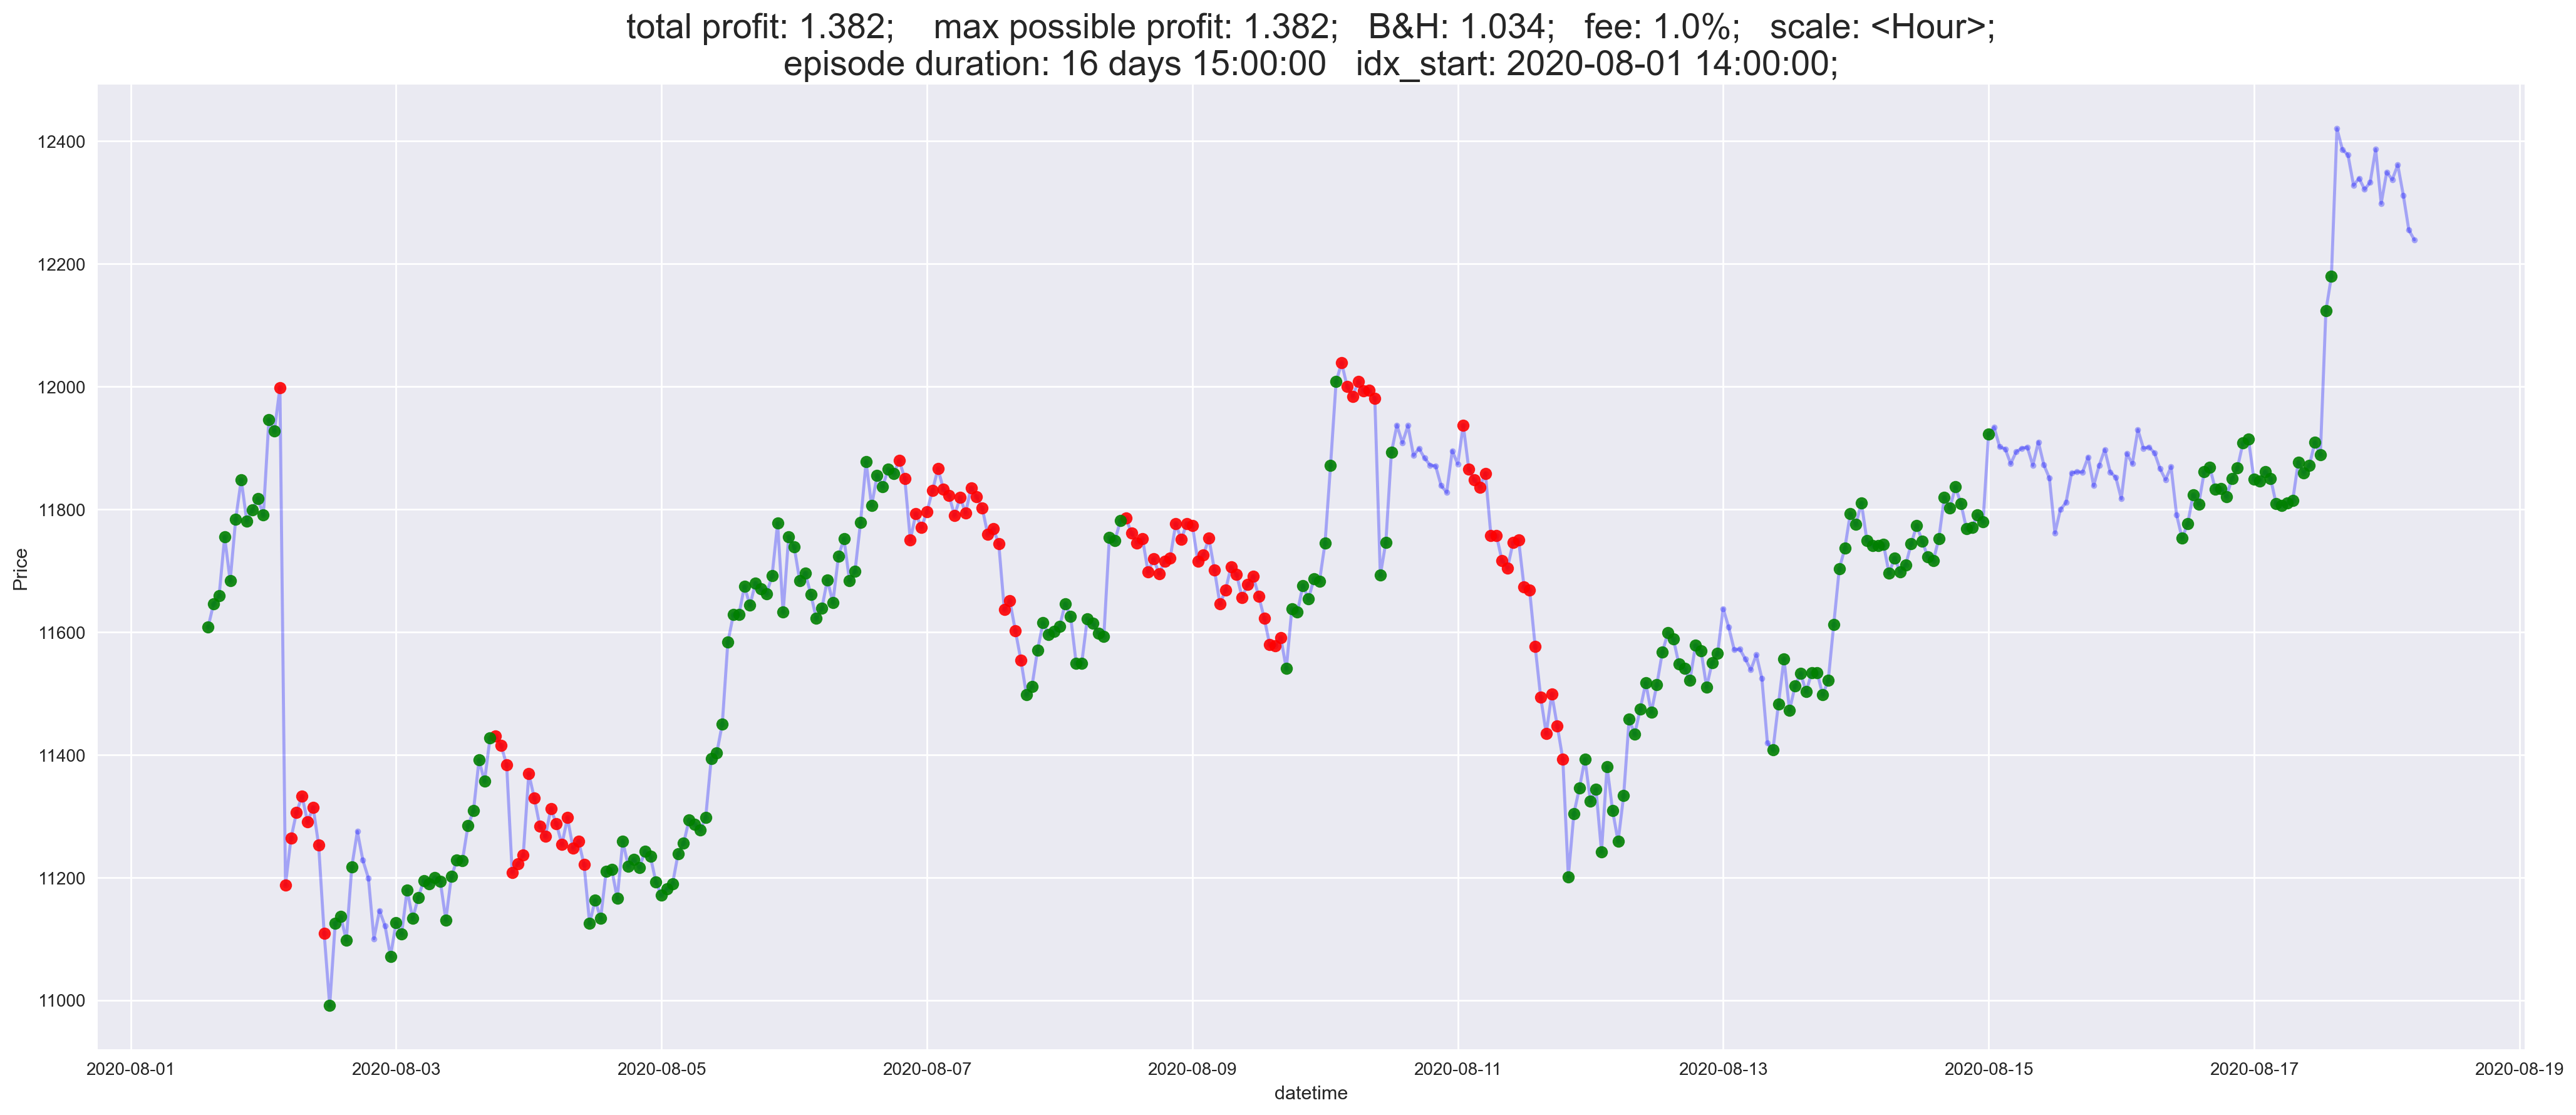

In [12]:
env.unwrapped.comission_fee = 0.01
obs, _ = env.reset()
while True:
    # obs: dict[features: np.ndarray, price_change: [float], position: [int], time_left: [float]]
    # action = env.action_space.sample()
    action = env.unwrapped.get_optimal_action()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break
env.render()